# Notebook 1: Data Loading and Visual Exploration

## Workshop Overview

Welcome to this hands-on workshop on biosensor data analysis! In this workshop, we'll work with physiological data recorded from two participants wearing biosensors.

### What you'll learn:
1. **Data Loading & Exploration** (this notebook)
2. **Quick Pipeline**: Using pre-computed heart rate for rapid synchrony analysis
3. **Comprehensive Pipeline**: ECG preprocessing, HRV analysis, and advanced synchrony metrics

### About the Data

We're using data from wearable biosensors that record:
- **ECG (Electrocardiogram)**: Raw electrical activity of the heart
- **Heart Rate (HR)**: Pre-computed beats per minute
- **Other sensors**: Temperature, accelerometer, gyroscope (not used today)

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Understanding the Folder Structure

Our data is organized as follows:

```
pilot1_3min/
├── 234130000540/          ← Participant 1 (sensor ID)
│   ├── ECG-*.csv
│   ├── HR-*.csv
│   └── ...
├── 234130000594/          ← Participant 2 (sensor ID)
│   ├── ECG-*.csv
│   ├── HR-*.csv
│   └── ...
└── Annotations-*.csv      ← Timing information
```

**Important**: Keep a separate log to track which sensor ID corresponds to which participant!

Example:
- Sensor 234130000540 = Participant A (experimenter)
- Sensor 234130000594 = Participant B (subject)


In [2]:
# Define data paths
data_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/data")  # Raw sensor data folder

# Sensor IDs - these correspond to your sensor device IDs
sensor_1 = "234130000540"
sensor_2 = "234130000594"

# Create a mapping for clearer naming
participant_mapping = {
    sensor_1: "Participant_A",
    sensor_2: "Participant_B"
}

print("✓ Data directory:", data_dir)
print("\nParticipant mapping:")
for sensor, name in participant_mapping.items():
    print(f"  Sensor {sensor} → {name}")

✓ Data directory: /Users/lena/Downloads/tutorial_dyadic_movesense/data

Participant mapping:
  Sensor 234130000540 → Participant_A
  Sensor 234130000594 → Participant_B


## 3. Loading Annotations: Defining the Experimental Window

The annotations file contains timestamps for key events during the recording.

### Key Concepts:

- **Unix Timestamp**: Seconds since January 1, 1970 (with microsecond precision)
- **Recording Start/Stop**: When the sensor system was turned on/off
- **Video/Audio Annotation Start/Stop**: The actual experimental period we want to analyze

We'll use the **VideoAnnotationStart** and **VideoAnnotationStop** to define our analysis window.

In [3]:
# Find the annotations file
annotation_file = list(data_dir.glob("Annotations-*.csv"))[0]
print(f"Found annotations file: {annotation_file.name}")

# Load annotations
annotations = pd.read_csv(annotation_file)
print("\nAnnotations:")
print(annotations)

Found annotations file: Annotations-2025_01_25-16_42_59.csv

Annotations:
      Timestamp                  Type  Content
0  1.737823e+09        RecordingStart      NaN
1  1.737823e+09        RecordingPause      NaN
2  1.737824e+09       RecordingResume      NaN
3  1.737824e+09  VideoAnnotationStart      NaN
4  1.737824e+09   VideoAnnotationStop      NaN
5  1.737824e+09         RecordingStop      NaN


In [4]:
# Extract experiment window timestamps
def get_experiment_window(annotations_df):
    """
    Extract start and end timestamps for the experimental window.
    Looks for VideoAnnotationStart/Stop or AudioAnnotationStart/Stop.
    """
    # Try video annotations first
    video_start = annotations_df[annotations_df['Type'] == 'VideoAnnotationStart']['Timestamp']
    video_stop = annotations_df[annotations_df['Type'] == 'VideoAnnotationStop']['Timestamp']
    
    if not video_start.empty and not video_stop.empty:
        start = video_start.values[0]
        end = video_stop.values[0]
        annotation_type = "Video"
    else:
        # Fall back to audio annotations
        audio_start = annotations_df[annotations_df['Type'] == 'AudioAnnotationStart']['Timestamp']
        audio_stop = annotations_df[annotations_df['Type'] == 'AudioAnnotationStop']['Timestamp']
        start = audio_start.values[0]
        end = audio_stop.values[0]
        annotation_type = "Audio"
    
    duration = end - start
    
    print(f"✓ Experiment window ({annotation_type}):")
    print(f"  Start: {start:.2f}")
    print(f"  End:   {end:.2f}")
    print(f"  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
    
    return start, end

exp_start, exp_end = get_experiment_window(annotations)

✓ Experiment window (Video):
  Start: 1737823570.85
  End:   1737824114.84
  Duration: 543.99 seconds (9.07 minutes)


## 4. Loading Raw ECG Data

### What is ECG?

**Electrocardiogram (ECG or EKG)** measures the electrical activity of your heart. Each heartbeat produces a characteristic waveform with distinct components:

```
       R
       |
   P   |   T
   /\  |  /\
  /  \ | /  \
 /    \|/    \
-------+-------
      Q S
```

- **P wave**: Atrial depolarization (atria contract)
- **QRS complex**: Ventricular depolarization (ventricles contract) - this is the heartbeat!
- **T wave**: Ventricular repolarization (ventricles relax)

The **R-peak** is the most prominent feature and is used to detect heartbeats.

In [5]:
def load_ecg_data(sensor_id, data_directory):
    """
    Load ECG data for a specific sensor.
    
    The ECG file has a header row with metadata, followed by:
    - Timestamp: Unix timestamp (seconds)
    - Sample: ECG amplitude value
    
    The header contains the sampling rate in the last 3 digits.
    Format: ECG<date><time><sampling_rate>
    """
    sensor_dir = data_directory / sensor_id
    ecg_file = list(sensor_dir.glob("ECG-*.csv"))[0]
    
    # Read the header to extract sampling rate
    with open(ecg_file, 'r') as f:
        header = f.readline().strip()
    
    # Extract sampling rate from the last 3 characters of the header
    # Header format: ECG<date><time><sampling_rate>
    sampling_rate = int(header[-3:])
    
    # Read the file, skipping the first row (metadata header)
    df = pd.read_csv(ecg_file, skiprows=1)
    
    print(f"✓ Loaded ECG for sensor {sensor_id}")
    print(f"  File: {ecg_file.name}")
    print(f"  Total samples: {len(df):,}")
    print(f"  Time range: {df['Timestamp'].min():.2f} to {df['Timestamp'].max():.2f}")
    print(f"  Duration: {(df['Timestamp'].max() - df['Timestamp'].min()):.2f} seconds")
    print(f"  Sampling rate (from header): {sampling_rate} Hz")
    
    return df, sampling_rate

# Load ECG for both participants
ecg_p1, sr_p1 = load_ecg_data(sensor_1, data_dir)
print()
ecg_p2, sr_p2 = load_ecg_data(sensor_2, data_dir)

✓ Loaded ECG for sensor 234130000540
  File: ECG-2025_01_25-16_42_59.csv
  Total samples: 113,856
  Time range: 1737823380.36 to 1737824121.31
  Duration: 740.95 seconds
  Sampling rate (from header): 200 Hz

✓ Loaded ECG for sensor 234130000594
  File: ECG-2025_01_25-16_42_59.csv
  Total samples: 112,320
  Time range: 1737823385.16 to 1737824120.55
  Duration: 735.39 seconds
  Sampling rate (from header): 200 Hz


## 5. Trimming Data to Experimental Window

Now we'll extract only the data that falls within our experimental window (between VideoAnnotationStart and VideoAnnotationStop).

In [6]:
def trim_to_window(df, start_time, end_time):
    """
    Trim dataframe to only include data within the specified time window.
    """
    mask = (df['Timestamp'] >= start_time) & (df['Timestamp'] <= end_time)
    trimmed = df[mask].copy()
    trimmed.reset_index(drop=True, inplace=True)
    
    print(f"  Original samples: {len(df):,}")
    print(f"  Trimmed samples:  {len(trimmed):,}")
    print(f"  Kept: {len(trimmed)/len(df)*100:.1f}%")
    
    return trimmed

# Trim both participants' ECG data
print("Trimming Participant 1 (sensor {}):".format(sensor_1))
ecg_p1_trimmed = trim_to_window(ecg_p1, exp_start, exp_end)

print("\nTrimming Participant 2 (sensor {}):".format(sensor_2))
ecg_p2_trimmed = trim_to_window(ecg_p2, exp_start, exp_end)

Trimming Participant 1 (sensor 234130000540):
  Original samples: 113,856
  Trimmed samples:  107,821
  Kept: 94.7%

Trimming Participant 2 (sensor 234130000594):
  Original samples: 112,320
  Trimmed samples:  107,360
  Kept: 95.6%


## 6. Visual Inspection: Raw ECG Signals

Let's visualize the raw ECG data to check signal quality and identify any artifacts.

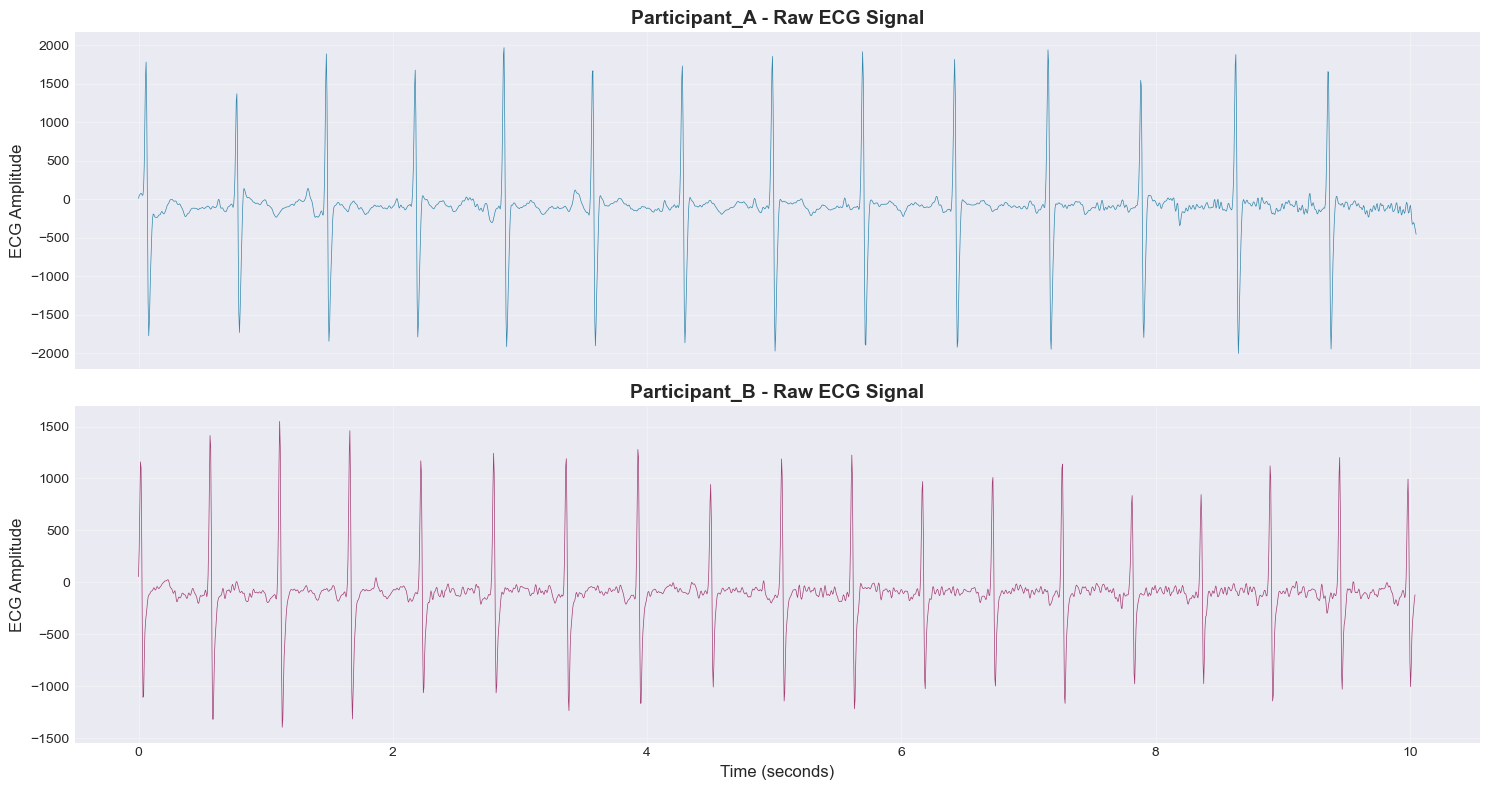


👀 What to look for:
  ✓ Regular R-peaks (sharp upward spikes)
  ✓ Consistent amplitude
  ✗ Large artifacts or flat regions (signal loss)
  ✗ Excessive noise or drift


In [7]:
def plot_ecg_overview(ecg_df1, ecg_df2, participant_names, window_seconds=10):
    """
    Plot a window of ECG data from both participants for visual inspection.
    
    Parameters:
    - window_seconds: Number of seconds to display (default: 10)
    """
    # Get a window of data from the middle of the recording
    start_idx1 = len(ecg_df1) // 2
    start_idx2 = len(ecg_df2) // 2
    
    # Calculate number of samples for the window
    window_samples1 = int(window_seconds * sr_p1)
    window_samples2 = int(window_seconds * sr_p2)
    
    # Extract windows
    window1 = ecg_df1.iloc[start_idx1:start_idx1 + window_samples1]
    window2 = ecg_df2.iloc[start_idx2:start_idx2 + window_samples2]
    
    # Create relative time in seconds
    time1 = window1['Timestamp'].values - window1['Timestamp'].values[0]
    time2 = window2['Timestamp'].values - window2['Timestamp'].values[0]
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    axes[0].plot(time1, window1['Sample'], linewidth=0.5, color='#2E86AB')
    axes[0].set_ylabel('ECG Amplitude', fontsize=12)
    axes[0].set_title(f'{participant_names[0]} - Raw ECG Signal', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(time2, window2['Sample'], linewidth=0.5, color='#A23B72')
    axes[1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1].set_ylabel('ECG Amplitude', fontsize=12)
    axes[1].set_title(f'{participant_names[1]} - Raw ECG Signal', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n👀 What to look for:")
    print("  ✓ Regular R-peaks (sharp upward spikes)")
    print("  ✓ Consistent amplitude")
    print("  ✗ Large artifacts or flat regions (signal loss)")
    print("  ✗ Excessive noise or drift")

# Plot 10 seconds of ECG from both participants
participant_names = [participant_mapping[sensor_1], participant_mapping[sensor_2]]
plot_ecg_overview(ecg_p1_trimmed, ecg_p2_trimmed, participant_names, window_seconds=10)

## 7. Loading Pre-computed Heart Rate Data

In addition to raw ECG, the sensors also provide pre-computed heart rate data.

### Heart Rate (HR) vs Inter-Beat Interval (IBI)

- **Heart Rate (HR)**: Number of beats per minute (BPM)
- **Inter-Beat Interval (IBI)**: Time between consecutive heartbeats (milliseconds)
- **RR Interval**: Same as IBI, named after the R-peaks in the ECG

These are inversely related: HR = 60,000 / IBI (when IBI is in milliseconds)

In [8]:
def load_hr_data(sensor_id, data_directory):
    """
    Load pre-computed heart rate data for a specific sensor.
    
    The HR file contains:
    - Average: Heart rate in BPM
    - RRData: RR interval in milliseconds
    
    The header contains the sampling rate (typically 1 Hz).
    Format: HeartRate<date><time><sampling_rate>
    """
    sensor_dir = data_directory / sensor_id
    hr_file = list(sensor_dir.glob("HR-*.csv"))[0]
    
    # Read the header to extract sampling rate
    with open(hr_file, 'r') as f:
        header = f.readline().strip()
    
    # Extract sampling rate from the last character(s) of the header
    # Header format: HeartRate<date><time><sampling_rate>
    # Typically this is just "1" for 1 Hz
    hr_sampling_rate = int(header[-1])
    
    # Read the file, skipping the first row (metadata header)
    df = pd.read_csv(hr_file, skiprows=1)
    
    print(f"✓ Loaded HR data for sensor {sensor_id}")
    print(f"  File: {hr_file.name}")
    print(f"  Total samples: {len(df):,}")
    print(f"  HR range: {df['Average'].min():.1f} - {df['Average'].max():.1f} BPM")
    print(f"  RR interval range: {df['RRData'].min():.0f} - {df['RRData'].max():.0f} ms")
    print(f"  Sampling rate (from header): {hr_sampling_rate} Hz")
    
    return df, hr_sampling_rate

# Load HR for both participants
hr_p1, hr_sr_p1 = load_hr_data(sensor_1, data_dir)
print()
hr_p2, hr_sr_p2 = load_hr_data(sensor_2, data_dir)

✓ Loaded HR data for sensor 234130000540
  File: HR-2025_01_25-16_42_59.csv
  Total samples: 871
  HR range: 71.3 - 153.1 BPM
  RR interval range: 272 - 1048 ms
  Sampling rate (from header): 1 Hz

✓ Loaded HR data for sensor 234130000594
  File: HR-2025_01_25-16_42_59.csv
  Total samples: 1,028
  HR range: 85.6 - 167.6 BPM
  RR interval range: 264 - 904 ms
  Sampling rate (from header): 1 Hz


## 8. Summary and Data Quality Check

Let's create a summary of what we've loaded.

In [9]:
print("=" * 60)
print("DATA LOADING SUMMARY")
print("=" * 60)

print(f"\n📁 Data Directory: {data_dir}")
print(f"⏱️  Experiment Duration: {(exp_end - exp_start):.1f} seconds ({(exp_end - exp_start)/60:.1f} minutes)")

print(f"\n👥 Participant 1 ({participant_mapping[sensor_1]}):")
print(f"   Sensor ID: {sensor_1}")
print(f"   ECG samples: {len(ecg_p1_trimmed):,}")
print(f"   HR samples: {len(hr_p1):,}")
print(f"   ECG sampling rate: {sr_p1:.0f} Hz")

print(f"\n👥 Participant 2 ({participant_mapping[sensor_2]}):")
print(f"   Sensor ID: {sensor_2}")
print(f"   ECG samples: {len(ecg_p2_trimmed):,}")
print(f"   HR samples: {len(hr_p2):,}")
print(f"   ECG sampling rate: {sr_p2:.0f} Hz")

print("\nData successfully loaded and ready for analysis!")
print("\n📊 Next steps:")
print("   → Notebook 2: Quick pipeline with pre-computed HR")
print("   → Notebook 3: Full ECG preprocessing and HRV analysis")

DATA LOADING SUMMARY

📁 Data Directory: /Users/lena/Downloads/tutorial_dyadic_movesense/data
⏱️  Experiment Duration: 544.0 seconds (9.1 minutes)

👥 Participant 1 (Participant_A):
   Sensor ID: 234130000540
   ECG samples: 107,821
   HR samples: 871
   ECG sampling rate: 200 Hz

👥 Participant 2 (Participant_B):
   Sensor ID: 234130000594
   ECG samples: 107,360
   HR samples: 1,028
   ECG sampling rate: 200 Hz

Data successfully loaded and ready for analysis!

📊 Next steps:
   → Notebook 2: Quick pipeline with pre-computed HR
   → Notebook 3: Full ECG preprocessing and HRV analysis


## 9. Export Prepared Data (Optional)

Save the trimmed data for use in subsequent notebooks.

In [11]:
# Create output directory
output_dir = Path("/Users/lena/Downloads/tutorial_dyadic_movesense/processed_data")
output_dir.mkdir(exist_ok=True)

# Save trimmed ECG data
ecg_p1_trimmed.to_csv(output_dir / f"ecg_{participant_mapping[sensor_1]}.csv", index=False)
ecg_p2_trimmed.to_csv(output_dir / f"ecg_{participant_mapping[sensor_2]}.csv", index=False)

# Save HR data
hr_p1.to_csv(output_dir / f"hr_{participant_mapping[sensor_1]}.csv", index=False)
hr_p2.to_csv(output_dir / f"hr_{participant_mapping[sensor_2]}.csv", index=False)

# Save metadata
metadata = {
    'exp_start': exp_start,
    'exp_end': exp_end,
    'duration_seconds': exp_end - exp_start,
    'sampling_rate_p1': sr_p1,
    'sampling_rate_p2': sr_p2,
    'hr_sampling_rate_p1': hr_sr_p1,
    'hr_sampling_rate_p2': hr_sr_p2,
    'sensor_1': sensor_1,
    'sensor_2': sensor_2,
    'participant_1': participant_mapping[sensor_1],
    'participant_2': participant_mapping[sensor_2]
}

import json
with open(output_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Data saved to {output_dir}/")
print("  Files created:")
for file in output_dir.glob("*"):
    print(f"    - {file.name}")

✓ Data saved to /Users/lena/Downloads/tutorial_dyadic_movesense/processed_data/
  Files created:
    - ecg_Participant_A.csv
    - hr_Participant_B.csv
    - ecg_Participant_B.csv
    - hr_Participant_A.csv
    - .DS_Store
    - metadata.json


---

## Notebook 1 Complete!

You've successfully:
- Loaded biosensor data from two participants
- Understood the folder structure and file formats
- Defined the experimental window using annotations
- Trimmed data to the relevant time period
- Visualized raw ECG signals for quality inspection
- Loaded pre-computed heart rate data

**Next up**: Notebook 2 - Quick Pipeline with Pre-computed HR 